# Linear Regression in StatsModels - Lab

## Introduction

It's time to apply the StatsModels skills from the previous lesson! In this lab , you'll explore a slightly more complex example to study the impact of spending on different advertising channels on total sales.

## Objectives

You will be able to:

* Perform a linear regression using StatsModels
* Evaluate a linear regression model using StatsModels
* Interpret linear regression coefficients using StatsModels

## Let's Get Started

In this lab, you'll work with the "Advertising Dataset", which is a very popular dataset for studying simple regression. [The dataset is available on Kaggle](https://www.kaggle.com/purbar/advertising-data), but we have downloaded it for you. It is available in this repository as `advertising.csv`. You'll use this dataset to answer this question:

> Which advertising channel has the strongest relationship with sales volume, and can be used to model and predict the sales?

The columns in this dataset are:

1. `sales`: the number of widgets sold (in thousands)
2. `tv`: the amount of money (in thousands of dollars) spent on TV ads
3. `radio`: the amount of money (in thousands of dollars) spent on radio ads
4. `newspaper`: the amount of money (in thousands of dollars) spent on newspaper ads

## Step 1: Exploratory Data Analysis

In [1]:
# Load necessary libraries and import the data
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('advertising.csv')

In [2]:
# Check the columns and first few rows
df.head(3)

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3


In [3]:
# Generate summary statistics for data with .describe()

#First, lemme get rid of that annoying duplicate index column.
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head(10)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,10.6


In [4]:
#Ok, now doing the summary statistics:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Based on what you have seen so far, describe the contents of this dataset. Remember that our business problem is asking us to build a model that predicts sales.

In [5]:
# Your answer here
"""Ok, I'm still not entirely sure what the 'sales' column represents, but I think each row represents \
a distinct product with how much was spend on TV, radio, and newspaper advertising and then that 'sales' \
column is how much each thing made the company (in thousands). If I'm right, then TV advertising is what \
this company is spending the most on. The other two don't get near as much of this company's advertising \
budget dollars, but newspaper is technically in second place."""

"Ok, I'm still not entirely sure what the 'sales' column represents, but I think each row represents a distinct product with how much was spend on TV, radio, and newspaper advertising and then that 'sales' column is how much each thing made the company (in thousands). If I'm right, then TV advertising is what this company is spending the most on. The other two don't get near as much of this company's advertising budget dollars, but newspaper is technically in second place."

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Every record in our dataset shows the advertising budget spend on TV, newspaper, and radio campaigns as well as a target variable, sales.

The count for each is 200, which means that we do not have any missing data.

Looking at the mean values, it appears that spending on TV is highest, and spending on radio is lowest. This aligns with what we see in the output from `head()`.
    
</details>

Now, use scatter plots to plot each predictor (TV, radio, newspaper) against the target variable.

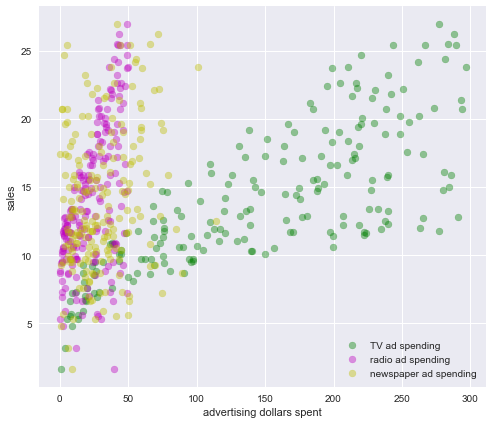

In [6]:
# Visualize the relationship between the predictors and the target using scatter plots
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(df['TV'], df['sales'], color='g', alpha=0.4, label='TV ad spending')
ax.scatter(df['radio'], df['sales'], color='m', alpha=0.4, label='radio ad spending')
ax.scatter(df['newspaper'], df['sales'], color='y', alpha=0.4, label='newspaper ad spending')
ax.set_xlabel('advertising dollars spent')
ax.set_ylabel('sales')
ax.legend();

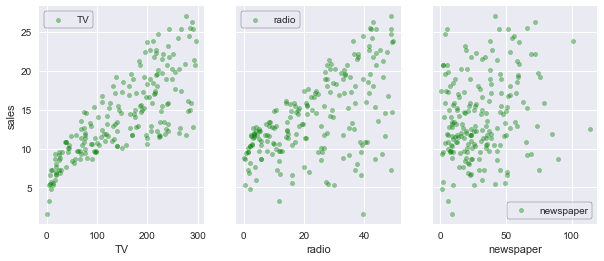

In [7]:
#Ugh, I didn't do it the best way. TV's ad dollars are so much more than the other two that
# I think it's making it hard to see the scale of the relationship among them. Subsequently, 
# we have to do one of those rows/columns axes things <(＿　＿)>

fig, ax = plt.subplots(ncols=3,nrows=1,sharey=True,figsize=(10,4))
for index, column in enumerate(['TV', 'radio', 'newspaper']):
#    ax[index].scatter(column, df['sales'], color='g', alpha=0.6)
#Close, but I can't get a label on each one. Try the solution's way:
    df.plot(kind='scatter', x=column, y='sales', color='g', alpha=0.4, ax=ax[index], label=column)
    ax[index].legend(frameon=True, edgecolor='k')

Does there appear to be a linear relationship between these predictors and the target?

In [8]:
# Record your observations on linearity here 
"""There's definitely a positive linear relationship in TV and radio (it's clearer with TV). \
However, I don't see a clear linear relationship emerging in newspaper advertising."""

"There's definitely a positive linear relationship in TV and radio (it's clearer with TV). However, I don't see a clear linear relationship emerging in newspaper advertising."

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

`TV` seems to be a good predictor because it has the most linear relationship with sales.

`radio` also seems to have a linear relationship, but there is more variance than with `TV`. We would expect a model using `radio` to be able to predict the target, but not as well as a model using `TV`.

`newspaper` has the least linear-looking relationship. There is a lot of variance as well. It's not clear from this plot whether a model using `newspaper` would be able to predict the target.
    
</details>

## Step 2: Run a Simple Linear Regression with `TV` as the Predictor

As the analysis above indicates, `TV` looks like it has the strongest relationship with `sales`. Let's attempt to quantify that using linear regression.

In [9]:
# Import libraries
#I done dit it earlier.
# Determine X and y values
X = df[['TV']]
y = df['sales']
# Create an OLS model
model = sm.OLS(endog=y, exog=sm.add_constant(X))
model

In [10]:
# Get model results
results = model.fit()
# Display results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           1.47e-42
Time:                        13:35:41   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step 3: Evaluate and Interpret Results from Step 2

How does this model perform overall? What do the coefficients say about the relationship between the variables?

In [11]:
# Your answer here
"""The results are definitely statistically significant with a low p-value. Is that saying the slope is 7? \
I think so. The R-squared is kind of meh at 0.61, though. Oh wait, no that 7 refers to the intercept. The \
slope is 0.0475. This is still a little hard to interpret, but that means for every 1 on the y-axis, so \
$1k in TV ad spending (note the scale there), they sell 47.5 more units (because we applied the same scale). \
We should remember to tone down notions of causation here, though."""

'The results are definitely statistically significant with a low p-value. Is that saying the slope is 7? I think so. The R-squared is kind of meh at 0.61, though. Oh wait, no that 7 refers to the intercept. The slope is 0.0475. This is still a little hard to interpret, but that means for every 1 on the y-axis, so $1k in TV ad spending (note the scale there), they sell 47.5 more units (because we applied the same scale). We should remember to tone down notions of causation here, though.'

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Overall the model and coefficients are **statistically significant**, with all p-values well below a standard alpha of 0.05.

The R-squared value is about 0.61 i.e. **61% of the variance in the target variable can be explained by TV spending**.

The intercept is about 7.0, meaning that if we spent 0 on TV, we would expect sales of about 7k widgets (the units of `sales` are in thousands of widgets).

The `TV` coefficient is about 0.05, meaning that **for each additional &dollar;1k spent on TV (the units of `TV` are in thousands of dollars), we would expect to sell an additional 50 widgets**. (More precisely, 47.5 widgets.)

Note that all of these coefficients represent associations rather than causation. It's possible that better sales are what leads to more TV spending! Either way, `TV` seems to have a strong relationship with `sales`.

</details>

## Step 4: Visualize Model with `TV` as Predictor

Create at least one visualization that shows the prediction line against a scatter plot of `TV` vs. sales, as well as at least one visualization that shows the residuals.

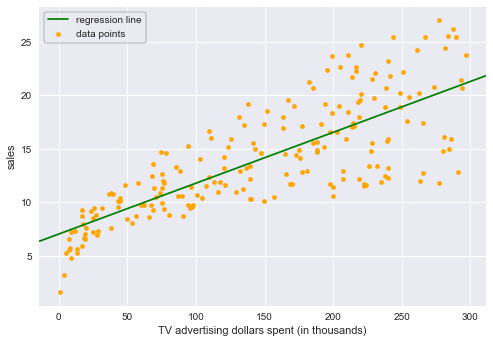

In [12]:
# Plot the model fit (scatter plot and regression line)
fig, ax = plt.subplots()
df.plot.scatter(x='TV', y='sales', color="orange", label="data points", ax=ax)
sm.graphics.abline_plot(model_results=results, color="g", label="regression line", ax=ax)
ax.set_xlabel("TV advertising dollars spent (in thousands)")
ax.legend(frameon=True, edgecolor='k');

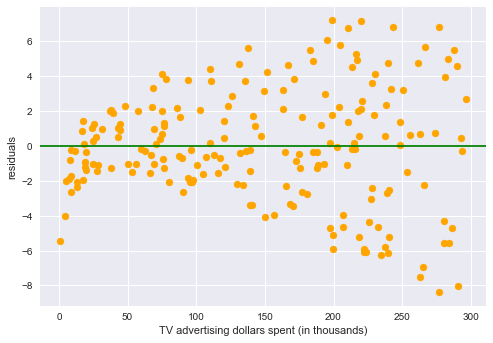

In [13]:
# Plot the model residuals
fig, ax = plt.subplots()

ax.scatter(df["TV"], results.resid, color="orange")
ax.axhline(y=0, color="g")
ax.set_xlabel("TV advertising dollars spent (in thousands)")
ax.set_ylabel("residuals");

## Step 5: Repeat Steps 2-4 with `radio` as Predictor

Compare and contrast the model performance, coefficient value, etc. The goal is to answer the business question described above.

In [14]:
# Run model
X = df[['radio']]
model = sm.OLS(endog=y, exog=sm.add_constant(X))
# Display results
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           4.35e-19
Time:                        13:35:42   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3116      0.563     16.542      0.000       8.202      10.422
radio          0.2025      0.020      9.921      0.000       0.162       0.243
==============================================================================
Omnibus:                       19.358   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.910
Skew:                          -0.764   Prob(JB):                     1.75e-05
Kurtosis:                       3.544   Cond. No.                         51.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

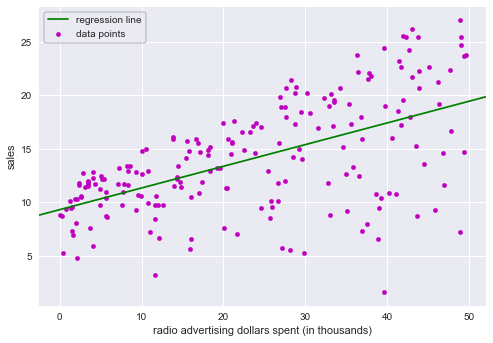

In [15]:
# Visualize model fit
fig, ax = plt.subplots()
df.plot.scatter(x='radio', y='sales', color="m", label="data points", ax=ax)
sm.graphics.abline_plot(model_results=results, color="g", label="regression line", ax=ax)
ax.set_xlabel("radio advertising dollars spent (in thousands)")
ax.legend(frameon=True, edgecolor='k');

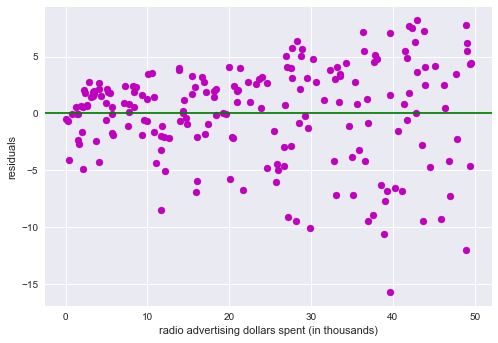

In [16]:
# Visualize residuals
fig, ax = plt.subplots()

ax.scatter(df["radio"], results.resid, color="m")
ax.axhline(y=0, color="g")
ax.set_xlabel("radio advertising dollars spent (in thousands)")
ax.set_ylabel("residuals");

In [17]:
# Your interpretation here
"""Definitely a significant relationship here, but only half as strong as TV was. \ 
So, this means they can expect to sell 20.25 more units for every $1k spent on \
radio advertising. Whoa I was wrong by a decimal place, though, it's an increase in \
202.5 units per $1k spent in radio ads."""

"Definitely a significant relationship here, but only half as strong as TV was. \\ \nSo, this means they can expect to sell 20.25 more units for every $1k spent on radio advertising. Whoa I was wrong by a decimal place, though, it's an increase in 202.5 units per $1k spent in radio ads."

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Same as with `TV`, the model using `radio` to predict `sales` as well as its parameters are **statistically significant** (p-values well below 0.05).

However, this model explains less of the variance. It only **explains about 33% of the variance in `sales`**, compared to about 61% explained by `TV`. If our main focus is the percentage of variance explained, this is a worse model than the `TV` model.

On the other hand, the coefficient for `radio` is much higher. **An increase of &dollar;1k in radio spending is associated with an increase of sales of about 200 widgets!** This is roughly 4x the increase of widget sales that we see for `TV`.

Visualizing this model, it doesn't look much different from the `TV` model.
    
So, how should we answer the business question? Realistically, you would need to return to your stakeholders to get a better understanding of what they are looking for. Do they care more about the variable that explains more variance, or do they care more about where an extra &dollar;1k of advertising spending is likely to make the most difference?

</details>

## Step 6: Repeat Steps 2-4 with `newspaper` as Predictor

Once again, use this information to compare and contrast.

In [18]:
# Run model
X = df[['newspaper']]
model = sm.OLS(endog=y, exog=sm.add_constant(X))
# Display results
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Fri, 13 Oct 2023   Prob (F-statistic):            0.00115
Time:                        13:35:43   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087
==============================================================================
Omnibus:                        6.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.483
Skew:                           0.330   Prob(JB):                       0.0645
Kurtosis:                       2.527   Cond. No.                         64.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

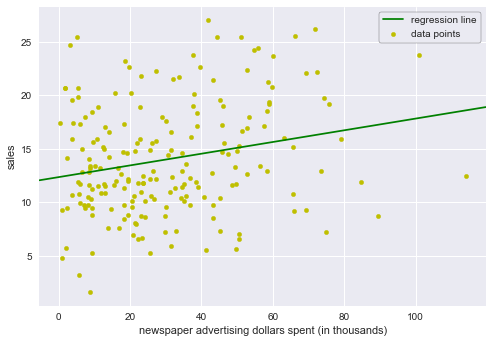

In [19]:
# Visualize model fit
fig, ax = plt.subplots()
df.plot.scatter(x='newspaper', y='sales', color="y", label="data points", ax=ax)
sm.graphics.abline_plot(model_results=results, color="g", label="regression line", ax=ax)
ax.set_xlabel("newspaper advertising dollars spent (in thousands)")
ax.legend(frameon=True, edgecolor='k');

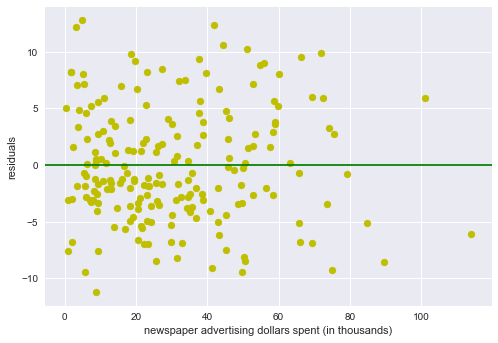

In [20]:
# Visualize residuals
fig, ax = plt.subplots()

ax.scatter(df["newspaper"], results.resid, color="y")
ax.axhline(y=0, color="g")
ax.set_xlabel("newspaper advertising dollars spent (in thousands)")
ax.set_ylabel("residuals");

In [21]:
# Your interpretation here
"""Newspaper ad spending's relationship with sales is a mess. While it is technically \
statistically significant, it's R-sqaured score is really low at 0.052. The residuals are \
so much larger than that of radio & TV. However, it looks like we can say that, for every \
$1k spent on newspaper ads, they can expect to sell 54.7 more units, so that's kind of interesting."""

"Newspaper ad spending's relationship with sales is a mess. While it is technically statistically significant, it's R-sqaured score is really low at 0.052. The residuals are so much larger than that of radio & TV. However, it looks like we can say that, for every $1k spent on newspaper ads, they can expect to sell 54.7 more units, so that's kind of interesting."

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>

Technically our model and coefficients are **still statistically significant** at an alpha of 0.05, but the p-values are much higher. For both the F-statistic (overall model significance) and the `newspaper` coefficient, our p-values are about 0.001, meaning that there is about a 0.1% chance that a variable with _no linear relationship_ would produce these statistics. That is a pretty small false positive rate, so we'll consider the model to be statistically significant and move on to interpreting the other results.

The R-Squared here is the smallest we have seen yet: 0.05. This means that **the model explains about 5% of the variance in `sales`**. 5% is well below both the `radio` model (33%) and the `TV` model (61%).

The coefficient is also small, though similar to the `TV` coefficient. **An increase of &dollar;1k in newspaper spending is associated with about 50 additional widget sales** (more precisely, about 54.7). This is still much less than the 200-widget increase associated with &dollar;1k of additional `radio` spending.

Visualizing this model, the best-fit line is clearly not a strong predictor. On the other hand, the residuals exhibit _homoscedasticity_, meaning that the distribution of the residuals doesn't vary much based on the value of `newspaper`. This contrasts with the `radio` and `TV` residuals which exhibit a "cone" shape, where the errors are larger as the x-axis increases. Homoscedasticity of residuals is a good thing, which we will describe more in depth when we discuss regression assumptions.

Once again, how should we answer the business question? Regardless of the framing, it is unlikely that `newspaper` is the answer that your stakeholders want. This model has neither the highest R-Squared nor the highest coefficient.

</details>

## Summary

In this lab, you ran a complete regression analysis with a simple dataset. You used StatsModels to perform linear regression and evaluated your models using statistical metrics as well as visualizations. You also reached a conclusion about how you would answer a business question using linear regression.